In [103]:
import matplotlib
#from tabulate import tabulate
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import re
from geopy.geocoders import Nominatim
import seaborn as sns
#from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
import folium
from folium.plugins import MarkerCluster

sns.set_theme(style="darkgrid")
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', None)

In [104]:
# Customize matplotlib
matplotlib.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
    'font.serif': 'cmr10',
    'mathtext.fontset': 'cm',
    'axes.unicode_minus': False,
})

In [105]:
# Due to mixed values, we will be treating most fields as text for now and see if there
# is anything to be done such that numerical values could be extracted out of these.
# There are however a few Boolean and Numerical types exceptions.

df = pd.read_csv(r"C:\Users\Acer\Documents\data madness\met_collection_cleaning\MetObjects.csv", dtype={
    'Gallery Number': str, 'Period': str,
    'Portfolio': str,
    'Dimensions': str

}, low_memory=False, nrows=20000)


#df = pd.read_csv(r"C:\Users\Tudor\PycharmProjects\Intelligent\MetObjects.txt", dtype={
#    'Gallery Number': str, 'Period': str,
#    'Portfolio': str,
#    'Dimensions': str
#
#}, low_memory=False, nrows=20000)

In [106]:
# We are only interested in the paintings and drawings
df = df.loc[df['Classification'].isin(['Paintings', 'Drawings'])]

# Re-order the columns such that <Object ID> is the first column.
# Other reorders should follow
df = df[
    ['Object ID', 'Department', 'AccessionYear', 'Object Name', 'Title', 'Culture',
     'Reign', 'Artist Display Name', 'Artist Nationality', 'Artist Begin Date', 'Artist End Date',
     'Artist Wikidata URL',
     'Object Begin Date', 'Object End Date', 'Medium', 'Dimensions',
     'City', 'Country', 'Classification', 'Object Wikidata URL', 'Tags']]

In [107]:
# Number of rows that have a value NaN
for column in df:
    print(column, len(df[pd.isnull(df[column])]), "/", len(df['Object ID']))

# In case we can fill the NaN values with 0
# df1 = df.copy()
# Fill all NaN values with 0

Object ID 0 / 5126
Department 0 / 5126
AccessionYear 3 / 5126
Object Name 0 / 5126
Title 0 / 5126
Culture 55 / 5126
Reign 5126 / 5126
Artist Display Name 283 / 5126
Artist Nationality 1442 / 5126
Artist Begin Date 343 / 5126
Artist End Date 309 / 5126
Artist Wikidata URL 406 / 5126
Object Begin Date 0 / 5126
Object End Date 0 / 5126
Medium 3 / 5126
Dimensions 2 / 5126
City 5080 / 5126
Country 4556 / 5126
Classification 0 / 5126
Object Wikidata URL 2825 / 5126
Tags 414 / 5126


In [108]:
# Displaying all values of the dataframe if necessary
pd.set_option("display.max_rows", None, "display.max_columns", None)

# Displaying all unique values in every column
# for col in df:
# print(col, df[col].unique())

In [109]:
# Clean up of the Culture column
df['Culture'] = df['Culture'].str.replace('for export', '')
df['Culture'] = df['Culture'].str.replace(', for Swedish market', ' (Swedish market)')
df['Culture'] = df['Culture'].str.replace(', for American market', ' (American market)')
df['Culture'] = df['Culture'].str.replace('or', ',')
df['Culture'] = df['Culture'].str.replace(', probably', '')
df['Culture'] = df['Culture'].str.replace(', possibly', '')
df['Culture'] = df['Culture'].str.replace('probably', '')

In [110]:
df.loc[:, 'Covered Area'] = -1
# print(tabulate(df, headers = 'keys', tablefmt = 'psql'))
# print(df.dtypes)

In [111]:
# select the items whose id and dimensions are not NaN
df = df[df['Object ID'].notna()]
df = df[df['Dimensions'].notna()]

In [112]:
# Several fields support multiple values, they should look similarly to the values
# at the <Tags> field in order to reduce the confusion.
df['Medium'] = df['Medium'].str.lower()
df['Medium'] = (df['Medium'].str.replace(", ", "|"))
df['Artist Nationality'] = (df['Artist Nationality'].str.replace(", ", "|"))

In [113]:
# Originally, the dimensions of each object are stored both in inches and centimeters
# Should only keep the centimeters dimensions
# i.e. 15 3/4 x 11 3/4 in. (40 x 29.8 cm) - > 40 x 29.8
# keeping in mind that the resulting column will denote the dimensions in cm
df['Dimensions'] = df['Dimensions'].apply(lambda st: st[st.find("(") + 1:st.find(")")])
df['Dimensions'] = (df['Dimensions'].str.replace("cm", ""))
df['Dimensions'] = (df['Dimensions'].str.replace(" ", ""))
df['Dimensions'] = (df['Dimensions'].str.replace("×", "x"))

In [114]:
# For now, it might not be the best idea to turn the <Dimensions> column into numerical types
# since there is a mixture of 2-dimensional and 3-dimensional items (e.g. 1 x 5.3 VS 2 x 4 x 8)
df['Dimensionality'] = df['Dimensions'].apply(lambda st: str.count(st, "x") + 1)

In [115]:
for index, (dimensionality, dimensions) in enumerate(zip(df['Dimensionality'], df['Dimensions'])):
    if (df.iloc[index]['Dimensionality']) == 1:
        df.at[index, 'Dimensionality'] = 2
        df.at[index, 'Dimensions'] = df.iloc[index]['Dimensions'] + "x" + df.iloc[index]['Dimensions']

In [116]:
# We can see that some of the items do not have a specified dimension, would rather delete
# those items since there's not much we can do with badly catalogued items like these.
df = df[~df['Dimensions'].str.contains("unavailabl", na=False)]
# besides unaivalable, there are: irregular, trimmed, bookletclosed, necklace, includingfur, eachscroll,
# Left, withbase, N.A, Eachapprox., each, bottomsection, variabl, topsection, trimmedtoplate, 
# also in these forms: 511/16in., SealFace;1.12x0.74\r\nHeight:0.56\r\nStringHole..., [nodimensionsavailable

In [117]:
# below we look for each object's dimensions, and if it doesn't contain a digit, we remove the row
# re.search(r'\d', inputString)
for index, dimensions in enumerate(df['Dimensions']):
    string = df.iloc[index]['Dimensions']
    nr_d = 0
    for c in string:
        if c.isdigit():
            nr_d += 1
    if (nr_d == 0): # if the dimensions contain no digit
        df.at[index, 'Dimensions'] = 'DELETE' # mark the item

df = df[~df['Dimensions'].str.contains("DELETE", na=False)] # delete the marked items

In [118]:
# convert columns to numeric values
df['AccessionYear'] = df['AccessionYear'].astype('float')
df['AccessionYear'] = df['AccessionYear'].astype('Int32')

df['Object ID'] = df['Object ID'].astype('Int64')
df['Dimensionality'] = df['Dimensionality'].fillna(0).astype('Int32')

df['Object Begin Date'] = pd.to_numeric(df['Object Begin Date'], errors='coerce')
df['Object End Date'] = pd.to_numeric(df['Object End Date'], errors='coerce')

df['Artist Begin Date'] = pd.to_numeric(df['Artist Begin Date'], errors='coerce')
df['Artist End Date'] = pd.to_numeric(df['Artist End Date'], errors='coerce')

In [119]:
# count the total covered area of each item
for index_item, item in df.iterrows():

    if (df['Dimensionality'][index_item] == 2):
        number_dimensions = []
        text_dimension = df['Dimensions'][index_item]
        number_dimensions = [float(s) for s in re.findall(r'-?\d+\.?\d*', text_dimension)]

        covered_area = np.prod(np.array(number_dimensions))
        df['Covered Area'][index_item] = covered_area

In [120]:
# Unfortunately, there are a couple dimensions that couldn't have been extracted
# given a really bad input when the item was introduced into the DB by the employees
# Since part of our analysis needs the area covered by each painting/drawing, we will only keep
# the ones with a good input
df = df[df['Dimensionality'] == 2]

In [121]:
# Clean up of the Country column
# USA -> United States
# US -> United States
# The United States -> United States
df['Country'] = df['Country'].str.replace('USA', 'United States')
df['Country'] = df['Country'].str.replace('US', 'United States')
df['Country'] = df['Country'].str.replace('The United States', 'United States')

In [122]:
# calculate the total time of working on each item
df['years_worked_item'] = df['Object End Date'] - df['Object Begin Date']
df['years_worked_item'] = pd.to_numeric(df['years_worked_item'], errors='coerce')

# calculate how long each artis lived
df['years_lived_artist'] = df['Artist End Date'] - df['Artist Begin Date']
df['years_lived_artist'] = pd.to_numeric(df['years_lived_artist'], errors='coerce')

In [123]:
# There are a couple outliers that have to be ignored throughout the plotting
# Definitely badly inserted data.
# Otherwise, a few 6000 values would show up
df = df[df['years_lived_artist'] < 120]

# Assuming we are not interesting in the extremely tiny ones
df = df[df['Covered Area'] > 10]

# There's only 1 extreme outlier that we'd like to remove
df = df[df['Covered Area'] < 200000]

C:\Users\Acer\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


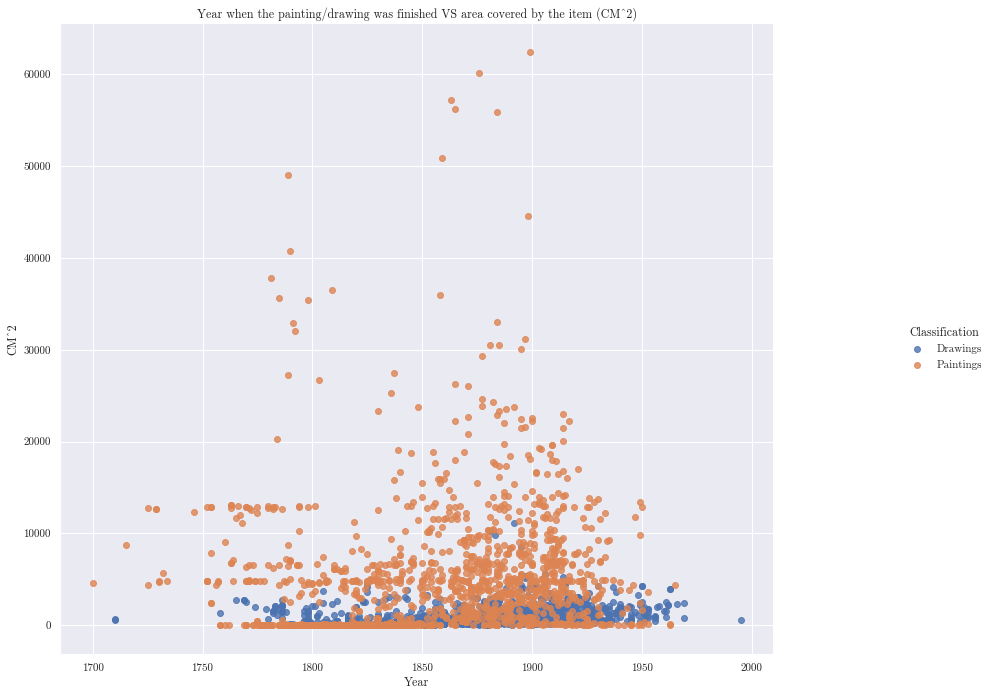

In [124]:
sns.lmplot('Object End Date', 'Covered Area', df, hue='Classification', fit_reg=False)
plt.title("Year when the painting/drawing was finished VS area covered by the item (CM^2)")
plt.xlabel("Year")
plt.ylabel("CM^2")
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

C:\Users\Acer\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


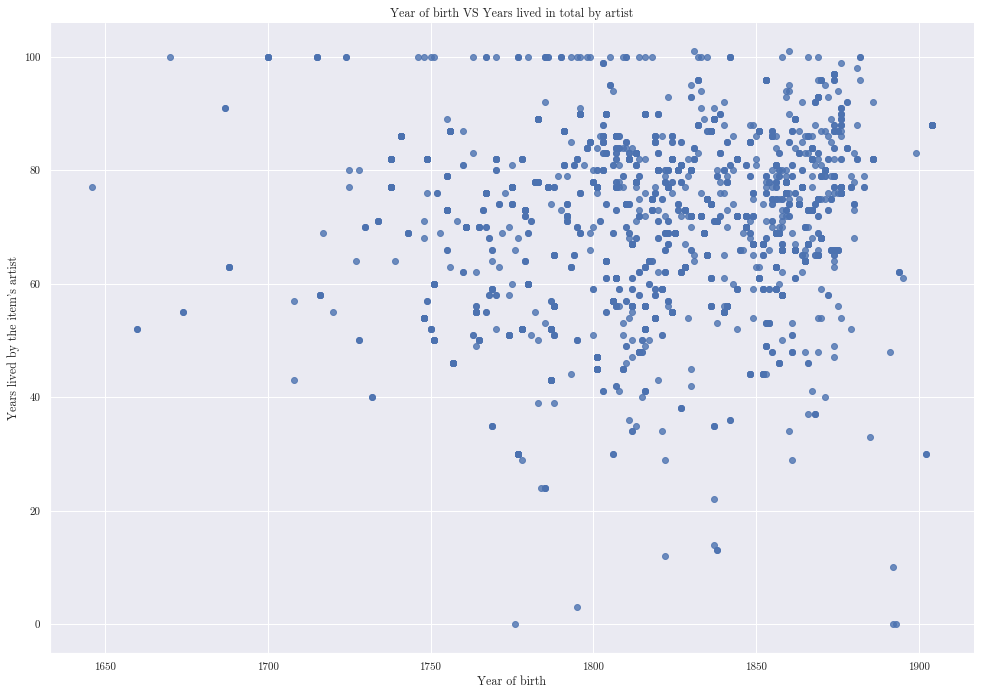

In [125]:
sns.lmplot('Artist Begin Date', 'years_lived_artist', df, fit_reg=False)
plt.title("Year of birth VS Years lived in total by artist")
plt.xlabel("Year of birth")
plt.ylabel("Years lived by the item's artist")
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

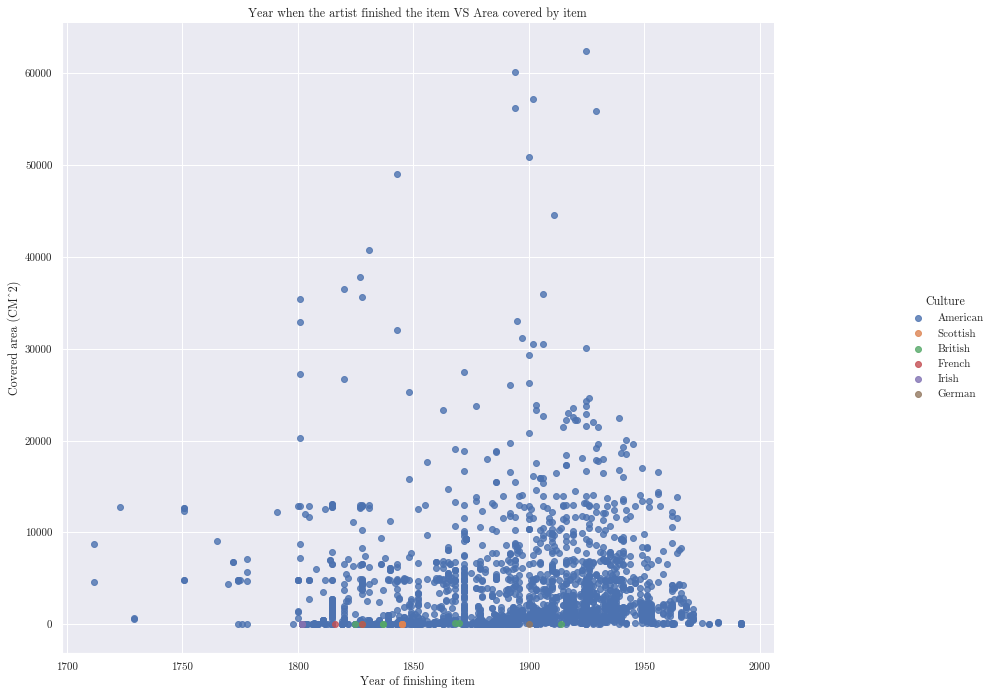

In [126]:
sns.lmplot('Artist End Date', 'Covered Area', df, hue='Culture', fit_reg=False)
plt.title("Year when the artist finished the item VS Area covered by item")
plt.xlabel("Year of finishing item")
plt.ylabel("Covered area (CM^2)")
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

C:\Users\Acer\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


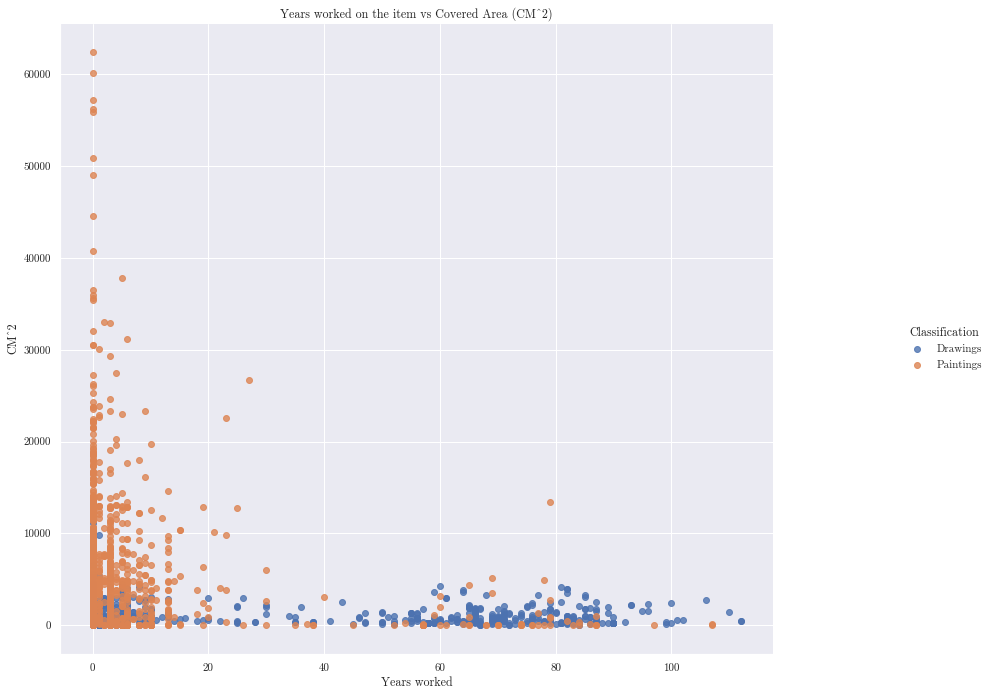

In [127]:
sns.lmplot('years_worked_item', 'Covered Area', df, hue='Classification', fit_reg=False)
plt.title("Years worked on the item vs Covered Area (CM^2)")
plt.xlabel("Years worked")
plt.ylabel("CM^2")
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

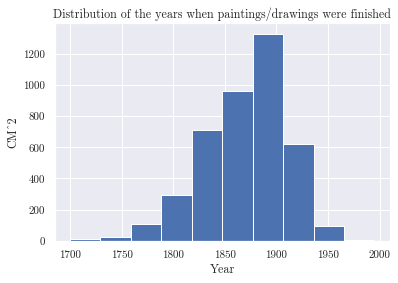

In [128]:
df["Object End Date"].plot(kind="hist")
plt.title("Distribution of the years when paintings/drawings were finished")
plt.xlabel("Year")
plt.ylabel("CM^2")
plt.show()

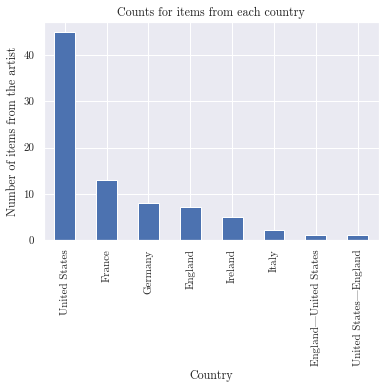

In [129]:
df['Country'].value_counts().plot(kind='bar')
plt.title("Counts for items from each country")
plt.xlabel("Country")
plt.ylabel("Number of items from the artist")
plt.show()

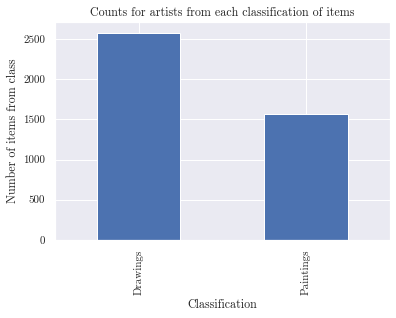

In [130]:
df['Classification'].value_counts().plot(kind='bar')
plt.title("Counts for artists from each classification of items")
plt.xlabel("Classification")
plt.ylabel("Number of items from class")
plt.show()

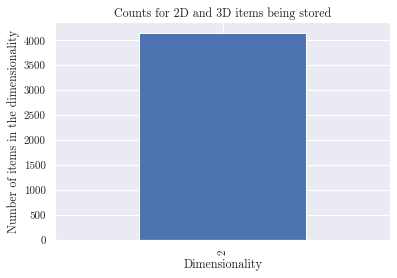

In [131]:
df['Dimensionality'].value_counts().plot(kind='bar')
plt.title("Counts for 2D and 3D items being stored")
plt.xlabel("Dimensionality")
plt.ylabel("Number of items in the dimensionality")
plt.show()

In [132]:
# We have to convert them back to int
df['Object Begin Date'] = df['Object Begin Date'].astype('Int32')
df['Object End Date'] = df['Object End Date'].astype('Int32')

df['Artist Begin Date'] = df['Artist Begin Date'].astype('Int32')
df['Artist End Date'] = df['Artist End Date'].astype('Int32')

# del df['years_lived_artist']
# del df['years_worked_item']

In [153]:
df

Object ID         Department  AccessionYear  \
137          150  The American Wing           1950   
163          194  The American Wing           1950   
414          471  The American Wing           1883   
428          485  The American Wing           1883   
474          533  The American Wing           1959   
475          534  The American Wing           1934   
877          955  The American Wing           1982   
1440        1559  The American Wing           1950   
1468        1596  The American Wing           1950   
1484        1617  The American Wing           1950   
1608        1755  The American Wing           1950   
1609        1756  The American Wing           1950   
1640        1787  The American Wing           1950   
1641        1788  The American Wing           1950   
1692        1848  The American Wing           1950   
1693        1849  The American Wing           1950   
1694        1850  The American Wing           1950   
1695        1851  The American Wing           1950   
1696        1852  The American Wing           1950   
1697        1853  The American Wing           1950   
1761        1917  The American Wing           1950   
1763        1919  The American Wing           1950   
1855        2014  The American Wing           1950   
3189        3409  The American Wing           1944   
3190        3410  The American Wing           1966   
3211        3431  The American Wing           1950   
3221        3447  The American Wing           1950   
3306        3538  The American Wing           1993   
3674        3926  The American Wing           1883   
3715        3970  The American Wing           1883   
3732        3991  The American Wing           1992   
4086        4411  The American Wing           1947   
4481        4827  The American Wing           1950   
4489        4836  The American Wing           1950   
4490        4837  The American Wing           1950   
4491        4838  The American Wing           1950   
4493        4840  The American Wing           1950   
4502        4854  The American Wing           1950   
4511        4867  The American Wing           1950   
4514        4870  The American Wing           1950   
4857        5223  The American Wing           1996   
5249        5629  The American Wing           1950   
5382        5763  The American Wing           1992   
5844        6240  The American Wing           1993   
6096        6498  The American Wing           1993   
6440        6900  The American Wing           1950   
6926        7399  The American Wing           1950   
7022        7499  The American Wing           1996   
7115        7596  The American Wing           1997   
7662        8168  The American Wing           1950   
7663        8169  The American Wing           1950   
9306       10028  The American Wing           1966   
9313       10035  The American Wing           1967   
9318       10042  The American Wing           1918   
9319       10043  The American Wing           1950   
9320       10044  The American Wing           1950   
9321       10049  The American Wing           1913   
9324       10056  The American Wing           1926   
9325       10057  The American Wing           1926   
9326       10058  The American Wing           1926   
9329       10061  The American Wing           1972   
9330       10062  The American Wing           1939   
9331       10063  The American Wing           1964   
9332       10064  The American Wing           1923   
9333       10065  The American Wing           1980   
9334       10066  The American Wing           1912   
9335       10067  The American Wing           1908   
9336       10068  The American Wing           1891   
9338       10070  The American Wing           1901   
9339       10071  The American Wing           1979   
9340       10072  The American Wing           1956   
9342       10074  The American Wing           1895   
9343       10075  The American Wing           1940   
9344       

In [151]:
dffff = df.groupby('Artist Display Name').agg(
    count=('Object ID', 'count'),
    total_covered=('Covered Area', sum)
) # total_worked=('years_worked_item', sum)

dffff['Average Covered Area'] = dffff.apply(lambda x: x['total_covered'] / x['count'], axis=1)
#dffff['Years Worked Average'] = dffff.apply(lambda x: x['total_worked'] / x['count'], axis=1)

In [154]:
df_years = df.groupby('Artist End Date').agg(count=('Object ID', 'count'),total_covered=('Covered Area', sum))
df_years['Average Covered Area'] = df_years.apply(lambda x: x['total_covered'] / x['count'], axis=1)

In [162]:
# do the same for years and see how avg covered area varies
df_years['Years'] = df_years.index
df_years.drop_index()


AttributeError: 'DataFrame' object has no attribute 'drop_index'

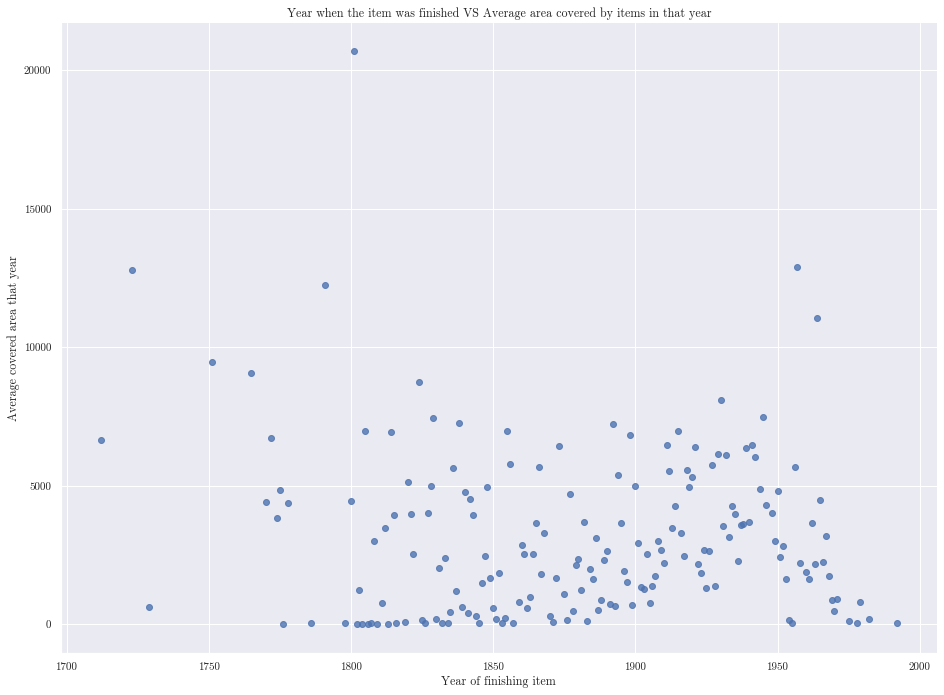

In [166]:
sns.lmplot('Years', 'Average Covered Area', df_years, fit_reg=False)
plt.title("Year when the item was finished VS Average area covered by items in that year")
plt.xlabel("Year of finishing item")
plt.ylabel("Average covered area that year")
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

In [135]:
# create a new dataframe for all unique artists
# df_new = df[['Artist Display Name']]

# unique_names = df_new['Artist Display Name'].unique()
# unique_names = pd.DataFrame(unique_names)
# unique_names['Count'] = 0
# unique_names['Total Covered Area'] = 0
# unique_names['Average Covered Area'] = 0

# unique_names['Years Worked Average'] = 0
# unique_names['Years Worked Total'] = 0

# unique_names.rename(columns={0: 'Name'}, inplace=True)

# unique_names['Works IDs'] = ''

In [149]:
# for index_item, item in df.iterrows():
#     for index_artist, artist in unique_names.iterrows():

#         if df['Artist Display Name'][index_item] == unique_names['Name'][index_artist]:
#             unique_names['Count'][index_artist] += 1
#             unique_names['Total Covered Area'][index_artist] += df['Covered Area'][index_item]
#             unique_names['Years Worked Total'][index_artist] += df['years_worked_item'][index_item]
#             # unique_names['Works IDs'] += (df['Object ID'][index_item] + '|')

#             # unique_names['Works'] = unique_names['Works'].apply(lambda x: x + [df['Object ID'][index_item]])


In [150]:
#unique_names['Average Covered Area'] = unique_names.apply(lambda x: x['Total Covered Area'] / x['Count'], axis=1)
#unique_names['Years Worked Average'] = unique_names.apply(lambda x: x['Years Worked Total'] / x['Count'], axis=1)

# keep only the artists with at least 2 paintings at Met
#unique_names = unique_names[unique_names['Count'] > 1]


# print(unique_names)
# print("----------------------------------------------------")
# print(df.head(10))